In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
#import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
#from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Load the dataset

- Load the train data and using all your knowledge of pandas try to explore the different statistical properties of the dataset.

In [23]:
# Code starts here

train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')
data_dict = pd.read_excel('FCDataDictionary.xlsx')

# Code ends here.

In [24]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2524,2744,96,17,30,-7,458,245,214,92,351,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
1,13295,2504,103,8,30,6,404,234,230,127,1510,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,4312,2311,30,7,0,0,1230,218,226,143,150,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,10656,2710,191,26,443,-45,1209,210,249,158,939,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,868,2802,91,11,540,18,1699,237,223,115,1084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [79]:
train.drop(['Id','Soil_Type7','Soil_Type15'],1,inplace=True)

In [80]:
train.shape

(9072, 53)

In [236]:
df = train.corr()
for column in df.columns.tolist():
    for row in df.index.tolist():
        if (abs(df.loc[row,column]) > 0.6) and (df.loc[row,column] < 1):
            print('{} and {}: {}'.format(row,column,df.loc[row,column]))

Wilderness_Area4 and Elevation: -0.7838164263939736
Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology: 0.6491943243847748
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology: 0.6491943243847748
Hillshade_3pm and Hillshade_9am: -0.8163258910349069
Hillshade_3pm and Hillshade_Noon: 0.6184232246482843
Hillshade_9am and Hillshade_3pm: -0.8163258910349069
Hillshade_Noon and Hillshade_3pm: 0.6184232246482843
Elevation and Wilderness_Area4: -0.7838164263939736


In [25]:
train_subset = train[['Horizontal_Distance_To_Roadways','Elevation','Horizontal_Distance_To_Fire_Points','Hillshade_3pm',
       'Aspect','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology','Hillshade_Noon',
       'Wilderness_Area1','Soil_Type29','Soil_Type30']].copy()

In [26]:
train_subset.columns

Index(['Horizontal_Distance_To_Roadways', 'Elevation',
       'Horizontal_Distance_To_Fire_Points', 'Hillshade_3pm', 'Aspect',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology',
       'Hillshade_Noon', 'Wilderness_Area1', 'Soil_Type29', 'Soil_Type30'],
      dtype='object')

### EDA & Data Preprocessing

- The target is the only categorical feature consisting of 7 classes and all the other features are continuous. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots. 

## Feature Engineering

In [8]:
def power_trans(df,col,power):
    lst = []
    for i in df[col]:
        if i < 0:
            lst.append(-np.power(abs(i),power))
        else:
            lst.append(np.power(i,power))
    return pd.DataFrame(lst)

def log_trans(df,col,base):
    lst = []
    for i in df[col]:
        if i < 0:
            lst.append(-np.log(abs(i)))
        elif i == 0:
            lst.append(np.log(1))
        else:
            lst.append(np.log(i))
    return pd.DataFrame(lst)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a360d4c90>]],
      dtype=object)

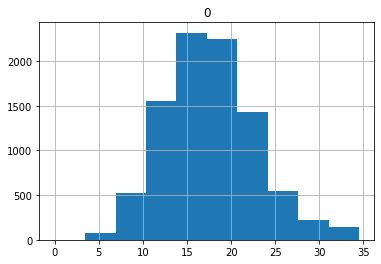

In [384]:
power_trans(train,'Horizontal_Distance_To_Fire_Points',0.4).hist()

In [81]:
train['Aspect'] = power_trans(train,'Aspect',0.6)
train['Slope'] = power_trans(train,'Slope',0.4)
train['Horizontal_Distance_To_Hydrology'] = power_trans(train,'Horizontal_Distance_To_Hydrology',0.4)
train['Vertical_Distance_To_Hydrology'] = power_trans(train,'Vertical_Distance_To_Hydrology',0.47)
train['Horizontal_Distance_To_Roadways'] = power_trans(train,'Horizontal_Distance_To_Roadways',0.4)

train['Hillshade_9am'] = power_trans(train,'Hillshade_9am',4.3)
train['Hillshade_Noon'] = power_trans(train,'Hillshade_Noon',4.7)

train['Horizontal_Distance_To_Fire_Points'] = power_trans(train,'Horizontal_Distance_To_Fire_Points',0.4)


In [27]:
# Train_subset Feature Engineering

train_subset['Aspect'] = power_trans(train_subset,'Aspect',0.6)

train_subset['Horizontal_Distance_To_Hydrology'] = power_trans(train_subset,'Horizontal_Distance_To_Hydrology',0.4)
train_subset['Vertical_Distance_To_Hydrology'] = power_trans(train_subset,'Vertical_Distance_To_Hydrology',0.47)
train_subset['Horizontal_Distance_To_Roadways'] = power_trans(train_subset,'Horizontal_Distance_To_Roadways',0.4)


train_subset['Hillshade_Noon'] = power_trans(train_subset,'Hillshade_Noon',4.7)

train_subset['Horizontal_Distance_To_Fire_Points'] = power_trans(train_subset,'Horizontal_Distance_To_Fire_Points',0.4)

### Feature Selection and Model building

- Separate the features and target and then split the train data into train and validation set.
- Apply different models of your choice and  then predict on the validation data and find the `accuracy_score` for this prediction.
- Try improving upon the `accuracy_score` using different feature selection techniques like wrapper methods, PCA and try using hyperparameter tuning to find the parameters that give the best accuracy.

## Model Run on Self made Subset of Train Data

In [43]:
# Code starts here
X = train_subset
y = train['Cover_Type']

for n in [5,7,9,11,13,15]:

    random_state = 0

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=random_state,test_size=0.3)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = LogisticRegression()

    #anova = SelectKBest(score_func = f_regression,  k = n)
    #X_train = anova.fit_transform(X_train,y_train)
    #X_test = anova.transform(X_test)

    
    #rfe = RFE(clf,n)

    #X_train = rfe.fit_transform(X_train,y_train)
    #X_test = rfe.transform(X_test)
    
    poly = PolynomialFeatures(2)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    print(accuracy_score(y_test,pred))

0.695077149155033
0.7167523879500367
0.7325495958853784
0.7270389419544453
0.7270389419544453
0.7270389419544453


## Model Run of Entire Train DataSet

In [94]:
# Code starts here
X = train.drop('Cover_Type',1)
y = train['Cover_Type']

for n in [15]:

    random_state = 0

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=random_state,test_size=0.3)
    
    print(X_test.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = RandomForestClassifier(max_depth = 15, random_state = 0, criterion = 'entropy')

    #anova = SelectKBest(score_func = f_regression,  k = n)
    #X_train = anova.fit_transform(X_train,y_train)
    #X_test = anova.transform(X_test)
    
    #pca = PCA(n_components=n,random_state=0)
    #X_train = pca.fit_transform(X_train)
    #X_test = pca.transform(X_test)
    
    #rfe = RFE(clf,n)

    #X_train = rfe.fit_transform(X_train,y_train)
    #X_test = rfe.transform(X_test)
    
    poly = PolynomialFeatures(2)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

    clf.fit(X_train,y_train)
    #pred = clf.predict(X_test)
    print(clf.score(X_train,y_train))
    print(clf.score(X_test,y_test))


# Code ends here

(2722, 52)
0.9995275590551181
0.8574577516531962


In [64]:
RandomForestClassifier?

In [46]:
for n in range(10):
    X = train.drop('Cover_Type',1)
    y = train['Cover_Type']

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=n,test_size=0.3)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = RandomForestClassifier()
    
    #rfe = RFE(clf,35)

    #X_train = rfe.fit_transform(X_train,y_train)
    #X_test = rfe.transform(X_test)
    
    poly = PolynomialFeatures(2)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    print(accuracy_score(y_test,pred))

0.8567229977957385
0.8405584129316679
0.8501102130786187
0.8497428361498898
0.8449669360764144
0.8486407053637032
0.8420279206465834
0.8468038207200588
0.840191036002939
0.840191036002939


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [100]:
test = pd.read_csv('test.csv')
Id = test['Id'].copy()

In [101]:
test.drop(['Id','Soil_Type7','Soil_Type15'],1,inplace=True)

In [102]:
test['Aspect'] = power_trans(test,'Aspect',0.6)
test['Slope'] = power_trans(test,'Slope',0.4)
test['Horizontal_Distance_To_Hydrology'] = power_trans(test,'Horizontal_Distance_To_Hydrology',0.4)
test['Vertical_Distance_To_Hydrology'] = power_trans(test,'Vertical_Distance_To_Hydrology',0.47)
test['Horizontal_Distance_To_Roadways'] = power_trans(test,'Horizontal_Distance_To_Roadways',0.4)

test['Hillshade_9am'] = power_trans(test,'Hillshade_9am',4.3)
test['Hillshade_Noon'] = power_trans(test,'Hillshade_Noon',4.7)

test['Horizontal_Distance_To_Fire_Points'] = power_trans(test,'Horizontal_Distance_To_Fire_Points',0.4)

In [103]:

random_state = 0

test = scaler.transform(test)

#clf = RandomForestClassifier(min_samples_split = 6, random_state = random_state, criterion = 'entropy')

#anova = SelectKBest(score_func = f_regression,  k = n)
#X_train = anova.fit_transform(X_train,y_train)
#X_test = anova.transform(X_test)
    
#pca = PCA(n_components=n,random_state=0)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
    
#rfe = RFE(clf,n)

#X_train = rfe.fit_transform(X_train,y_train)
#X_test = rfe.transform(X_test)

test = poly.transform(test)

pred = clf.predict(test)



In [107]:
submission = pd.DataFrame({'Id': Id, 'Cover_Type': pred})
submission.to_csv('first submission.csv',index = False)

In [105]:
sample_submission

,Id,Cover_Type
0,6376,5
1,8962,7
2,7122,5
3,931,5
4,3678,6
...,...,...
6043,3982,4
6044,8524,6
6045,4332,4
6046,4935,4
